In [64]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from scipy.stats import skew
import statsmodels.api as sm
import numpy as np
from scipy import stats

df = pd.read_csv('microwage.csv')

Occupation Encoding

In [65]:
# occu = ['occ_managprof', 'occ_techsalad', 'occ_service', 'occ_farm', 'occ_product',	'occ_operator',	'occ_service_np', 'occ_service_broad']

# df['occupation'] = df[occu].idxmax(axis=1)
# df = df.drop(columns=occu)

# occu_encodings = {col : occu.index(col)+1 for col in occu}
# df['occupation'] = df['occupation'].replace(occu_encodings)

# occu_encodings = {col : occu.index(col) for col in occu}
# df['occupation'] = df['occupation'].replace(occu_encodings)

Removing Outliers

In [66]:
cols = ['edyrs', 'expyrs', 'wkwage', 'perwt']

for col in cols:
    quartiles = df[col].quantile([0.20, 0.80])
    q1 = quartiles.loc[0.20]
    q3 = quartiles.loc[0.80]

    low_bound = q1 - 1.5 * (q3 - q1)
    upp_bound = q3 + 1.5 * (q3 - q1)

    df = df[(df[col] >= low_bound) & (df[col] <= upp_bound)]



One hot encoding

In [67]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# Define MinMaxScaler
scaler = MinMaxScaler()

# Apply Min-Max scaling to the entire DataFrame
scaled_values = scaler.fit_transform(df)

# Convert scaled values back to DataFrame
df = pd.DataFrame(scaled_values, columns=df.columns)

df


,region,statefip,metaread,puma,perwt,age,female,race_nonwhite,edyrs,occ_managprof,occ_techsalad,occ_service,occ_farm,occ_product,occ_operator,occ_service_np,occ_service_broad,industry,expyrs,wkwage
0,1.000000,0.090909,0.552350,0.032197,0.297959,0.041667,0.0,0.0,0.452142,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.020612,0.034790
1,1.000000,0.090909,0.072650,0.048933,0.367347,0.270833,0.0,0.0,0.452142,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.245102,0.197818
2,1.000000,0.090909,0.724359,0.099154,0.889796,0.083333,1.0,0.0,0.576117,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.033673,0.187282
3,1.000000,0.090909,0.798077,0.084980,0.220408,0.479167,1.0,0.0,0.018232,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.489796,0.051830
4,1.000000,0.090909,0.867521,0.023186,0.195918,0.520833,1.0,0.0,0.453054,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.489796,0.657068
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1214392,0.032258,0.636364,0.598291,0.050337,0.987755,0.208333,0.0,1.0,0.596171,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.151633,0.092192
1214393,0.645161,0.418182,0.944444,0.012938,0.436735,0.645833,0.0,0.0,0.656335,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.566735,0.789295
1214394,0.322581,0.290909,0.170940,0.039947,0.371429,0.125000,0.0,0.0,0.656335,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.056531,0.149657
1214395,0.645161,0.418182,0.076923,0.003862,0.269388,0.812500,0.0,0.0,0.970830,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.659592,0.234691


Handling Skewness

In [69]:
skewed_columns = df.apply(lambda x: skew(x))

print("Before Handling Skewness:")
print(skewed_columns)

skewed_columns = skewed_columns[(skewed_columns > 0.5) | (skewed_columns < -0.5)]

for col in skewed_columns.index:
    if skewed_columns[col] > 0.5:
        df[col] = np.log1p(df[col])
    elif skewed_columns[col] < -0.5:
        df[col] = np.cbrt(df[col])

print("\nAfter Handling Skewness:")
print(df.apply(lambda x: skew(x)))


Before Handling Skewness:
region               -0.194350
statefip             -0.008125
metaread              0.330860
puma                 14.947650
perwt                 1.035947
age                  -0.067944
female               -0.053071
race_nonwhite         1.888441
edyrs                -0.064044
occ_managprof         0.807263
occ_techsalad         0.852218
occ_service           1.803953
occ_farm             10.970862
occ_product           2.808172
occ_operator          2.380230
occ_service_np        1.944458
occ_service_broad     1.114497
industry             -0.898097
expyrs                0.012287
wkwage                1.017745
dtype: float64

After Handling Skewness:
region               -0.194350
statefip             -0.008125
metaread              0.330860
puma                  8.307681
perwt                 0.637739
age                  -0.067944
female               -0.053071
race_nonwhite         1.888441
edyrs                -0.064044
occ_managprof         0.807263
occ

In [70]:
# sns.set_theme(rc = {'figure.figsize':(10, 7)})
# sns.heatmap(df.corr(), cmap='viridis', fmt='.2f', cbar_kws={'label': 'Correlation Coefficient'}, annot=True)
# plt.title('Heatmap of Column Correlation')
# plt.show()

In [71]:
# columns = ['industry']

# for col in columns:
#     one_hot_encoded = pd.get_dummies(df[col], prefix=col)
#     df = pd.concat([df, one_hot_encoded], axis=1)
#     df = df.replace({True: 1, False: 0})
#     df = df.drop(columns=[col])


In [72]:
df = df.drop(columns=['region', 'statefip', 'race_nonwhite', 'puma', 'occ_farm', 'occ_product', 'industry'])

Handling Non-linearity

In [73]:

# fig, axes = plt.subplots(2, 3, figsize=(20, 10))


# sns.histplot(x=df['age'], ax=axes[0, 0], color='orange', kde=True)
# axes[0, 0].set_title('Age')

# sns.histplot(x=df['edyrs'], ax=axes[0, 1], color='orange', kde=True)
# axes[0, 1].set_title('Edyrs')


# sns.histplot(x=df['expyrs'], ax=axes[0, 2], color='orange', kde=True)
# axes[0, 2].set_title('Expyrs')

# sns.histplot(x=df['perwt'], ax=axes[1, 0], color='orange', kde=True)
# axes[1, 0].set_title('Perwt')

# sns.histplot(x='wkwage', data=df, ax=axes[1, 1], color='orange', kde=True)
# axes[1, 2].set_title('Wkwage')


# plt.tight_layout()
# plt.show()

In [74]:
# fig, axes = plt.subplots(2, 3, figsize=(20, 10))

# # sns.scatterplot(x=df['puma'], y = df['wkwage'], ax=axes[0, 0], color='skyblue')
# # axes[0, 0].set_title('Puma')

# sns.scatterplot(x=df['perwt'], y = df['wkwage'], ax=axes[0,0], color='skyblue')
# axes[0, 0].set_title('Perwt')

# sns.scatterplot(x='age', data=df,y = df['wkwage'], ax=axes[0, 1], color='skyblue')
# axes[0, 1].set_title('Age')

# sns.scatterplot(x=df['expyrs'], y = df['wkwage'], ax=axes[0, 2], color='skyblue')
# axes[1, 0].set_title('Expyrs')

# sns.scatterplot(x=df['edyrs'], y = df['wkwage'], ax=axes[1, 0], color='skyblue')
# axes[1, 1].set_title('Edyrs')

# sns.scatterplot(x=df['metaread'], y = df['wkwage'], ax=axes[1, 1], color='skyblue')
# axes[1, 2 ].set_title('Metaread')

# plt.tight_layout()

# plt.show()

Model 1

In [75]:
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
import statsmodels.api as sm

X = df
X = X.drop(columns=['wkwage'])
y = df[['wkwage']]

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

ols_model = sm.OLS(y, X).fit()

print("MSE ", np.mean(ols_model.resid ** 2))
print(ols_model.summary())

MSE  0.015029629966517903
                                 OLS Regression Results                                
Dep. Variable:                 wkwage   R-squared (uncentered):                   0.815
Model:                            OLS   Adj. R-squared (uncentered):              0.815
Method:                 Least Squares   F-statistic:                          4.450e+05
Date:                Wed, 20 Mar 2024   Prob (F-statistic):                        0.00
Time:                        00:36:03   Log-Likelihood:                      8.2570e+05
No. Observations:             1214397   AIC:                                 -1.651e+06
Df Residuals:                 1214385   BIC:                                 -1.651e+06
Df Model:                          12                                                  
Covariance Type:            nonrobust                                                  
                        coef    std err          t      P>|t|      [0.025      0.975]
--------

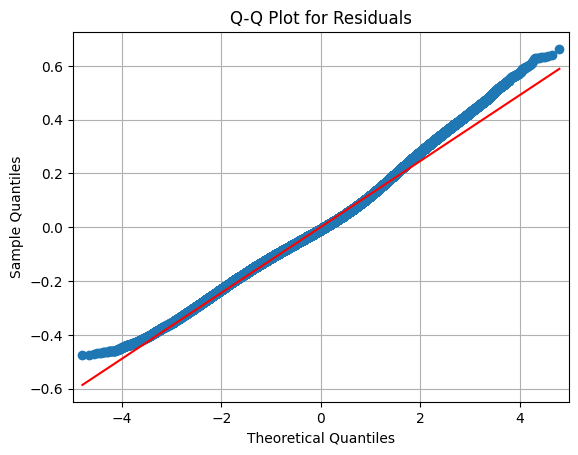

In [76]:
sm.qqplot(ols_model.resid, line='s')
plt.title('Q-Q Plot for Residuals')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Sample Quantiles')
plt.grid(True)
plt.show()

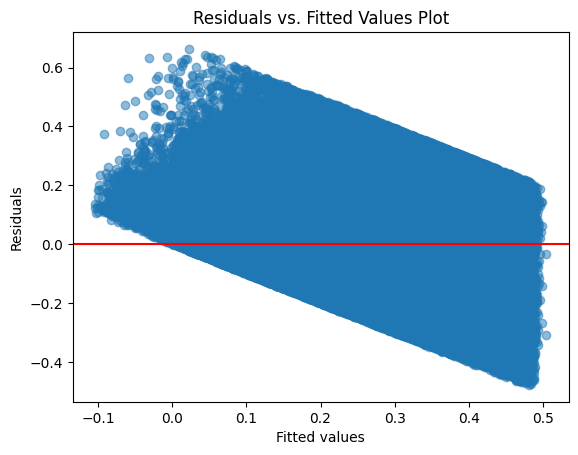

In [77]:
plt.scatter(ols_model.fittedvalues, ols_model.resid, alpha=0.5)
plt.xlabel("Fitted values")
plt.ylabel("Residuals")
plt.title("Residuals vs. Fitted Values Plot")
plt.axhline(y=0, color='r', linestyle='-')
plt.show()

In [78]:
# import statsmodels.api as sm
# from statsmodels.compat import lzip
# from statsmodels.stats.diagnostic import het_breuschpagan

# lm, lm_p_value, fvalue, f_p_value = het_breuschpagan(ols_model.resid, X_train)

# # Print the test results
# print("Lagrange Multiplier Test:", lm)
# print("Lagrange Multiplier Test p-value:", lm_p_value)
# print("F-statistic:", fvalue)
# print("F-statistic p-value:", f_p_value)

Model 2

In [79]:
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
import statsmodels.api as sm

X = df
X = X.drop(columns=['wkwage', 'occ_techsalad'])
y = df[['wkwage']]

ols_model = sm.OLS(y, X).fit()

print("MSE ", np.mean(ols_model.resid ** 2))
print(ols_model.summary())

MSE  0.015029632042355554
                                 OLS Regression Results                                
Dep. Variable:                 wkwage   R-squared (uncentered):                   0.815
Model:                            OLS   Adj. R-squared (uncentered):              0.815
Method:                 Least Squares   F-statistic:                          4.854e+05
Date:                Wed, 20 Mar 2024   Prob (F-statistic):                        0.00
Time:                        00:36:06   Log-Likelihood:                      8.2570e+05
No. Observations:             1214397   AIC:                                 -1.651e+06
Df Residuals:                 1214386   BIC:                                 -1.651e+06
Df Model:                          11                                                  
Covariance Type:            nonrobust                                                  
                        coef    std err          t      P>|t|      [0.025      0.975]
--------

In [80]:
# # Define hyperparameters to tune
# alpha_values = [0.01, 0.05, 0.1, 0.5, 1.0]  # Regularization parameter
# l1_wt_values = [0, 0.25, 0.5, 0.75, 1.0]     # L1_wt parameter
# maxiter_values = [100, 200, 300]             # Maximum number of iterations
# methods = ['pinv', 'qr']       # Methods for the solver

# best_mse = float('inf')
# best_params = None
# best_model = None

# # Iterate over hyperparameters
# for alpha in alpha_values:
#     for l1_wt in l1_wt_values:
#         for maxiter in maxiter_values:
#             for method in methods:
#                 # Fit the OLS model
#                 ols_model = sm.OLS(y_train, X_train).fit(alpha=alpha, L1_wt=l1_wt, start_params=None, maxiter=maxiter, method=method)
    
#                 # Calculate mean squared error
#                 mse = np.mean(ols_model.resid ** 2)
    
#                 # Check if this model's MSE is better than the best MSE found so far
#                 if mse < best_mse:
#                     best_mse = mse
#                     best_params = {'alpha': alpha, 'L1_wt': l1_wt, 'maxiter': maxiter, 'method': method}
#                     best_model = ols_model

# # Print best hyperparameters and model summary
# print("Best hyperparameters:", best_params)
# print("Best MSE:", best_mse)
# print(best_model.summary())